<div style='background-color: #910c22; color: #ffffff; padding: 20px 40px; text-align: center;'>
    <h1 style='font-size: 42px; padding: 0px; margin: 0px; margin-bottom: 5px;'>Projet Epidémiologie</h1>
    <h2 style='font-size: 24px; padding: 0px; margin: 0px;'>MDI230 - Files d'attente (S2-P4)</h2>
    <h3 style='font-size: 12px;'>Bruno Pons, Julia Soledad Montes, Mauro Parafati</h3>
</div>

<div style='background-color: #ffffff; color: #910c22; border: 5px solid #910c22; padding: 20px 40px;'>
    <h1 style='font-size: 32px; padding: 0px; margin: 0px;'>Table of Contents</h1>
</div>

* [Setup](#Setup) *(imports, libraries installation, etc)*
* [Présentation](#1.-Présentation)
* [Travail à effectuer](#2.-Travail-à-effectuer)
    * [Deterministic system SIR](#Deterministic-system-SIR)
    * [Markov process for a population of N individuals](#Markov-process-for-a-population-of-N-individuals)
    * [Find pairs of values ($ \beta, \gamma$)](#Find-pairs-of-values-($-\beta,-\gamma$))
    * [Illustrate graphically the convergence of the renormalised Markov process towards the solution of the deterministic system](#Illustrate-graphically-the-convergence-of-the-renormalised-Markov-process-towards-the-solution-of-the-deterministic-system)
    * [Parameter estimation from French public health data](#Parameter-estimation-from-French-public-health-data)

<div style='background-color: #ffffff; color: #3b3b3b; border: 5px solid #3b3b3b; padding: 20px 40px;'>
    <h1 style='font-size: 32px; padding: 0px; margin: 0px;'>Setup</h1>
</div>

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import statistics 

<div style='background-color: #ffffff; color: #f09516; border: 5px solid #f09516; padding: 20px 40px;'>
    <h1 style='font-size: 32px; padding: 0px; margin: 0px; margin-bottom: 5px;'>1. Présentation</h1>
</div>

Il s'agit de voir les différences entre le modèle markovien et le modèle déterministe de la diffusion d'une épidémie. Vous devez rendre un fichier unique soit en pdf, soit en ipynb.

<div style='background-color: #ffffff; color: #026be3; border: 5px solid #026be3; padding: 20px 40px;'>
    <h1 style='font-size: 32px; padding: 0px; margin: 0px; margin-bottom: 5px;'>2. Travail à effectuer</h1>
</div>

<h2 style='color: #026be3;'>Deterministic system SIR</h2>

The population, $N$  is divided into three categories:

- $S(t)$ : susceptible to be infected
- $I(t)$ : infected 
- $R(t)$ : recovered from the disease with immunity


The $SIR$ model, depends on $\beta$ and $\gamma$ parameters, where:

- $\beta > 0 $ is the rate of contraction of the disease (transmission parameter)
- $\gamma > 0 $ is the mean recovery rate


The model is based on the following assumptions:

- On average, an individual $S$ in the population encounters $\beta$ individuals per unit time
- The rate of infected individuals leaving compartment I is $\gamma I$ per unit time (once an individual has been infected, he develops immunity to the disease).
- The population size $N = S+I+R$ is constant.

The system of equations of the model is given by:

$$\left\lbrace\begin{array}{c} \frac{dS}{dt} = -\beta S I \\
\frac{dI}{dt} = \beta S I -\gamma I \\
\frac{dR}{dt} = \gamma I
\end{array}\right.$$

These equations describe the rate of change of each compartment over time. The first equation represents the change in the susceptible population, which decreases as individuals become infected. The second equation represents the change in the infected population, which increases due to new infections and decreases as individuals recover. The third equation represents the change in the recovered population, which increases as individuals recover from the disease.

In [2]:
# Differential equations for the SIR model
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Plot function for S(t), I(t), R(t)
def plot(S, I, R, t, divide_by=1, title=''):
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.plot(t, np.array(S) / divide_by, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, np.array(I) / divide_by, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, np.array(R) / divide_by, 'g', alpha=0.5, lw=2, label='Recovered from the disease')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel(f'Number of individuals')
    ax.set_title(rf"{title}")
    ax.set_xlim(0, max(t))
    ax.set_ylim(0, max(np.array(S) / divide_by)*1.05)
    ax.grid(True)
    legend = ax.legend()

In [3]:
# Initial conditions
N = 3426_000 # Initial population (we consider the population of Uruguay)
I0 = 1_000 # Number of initial infected
R0 = 0 # Number of initial recovered individuals
S0 = N - I0 - R0 # Number of initial susceptible individuals

# Infection and recovery rates
beta = 0.2 # Infection rate
gamma = 0.02 # Recovery rate

# Initial conditions vector
y0 = S0, I0, R0

# Days (in days)
t_max = 360

# A grid of time points (in days)
t = np.linspace(0, t_max, t_max)

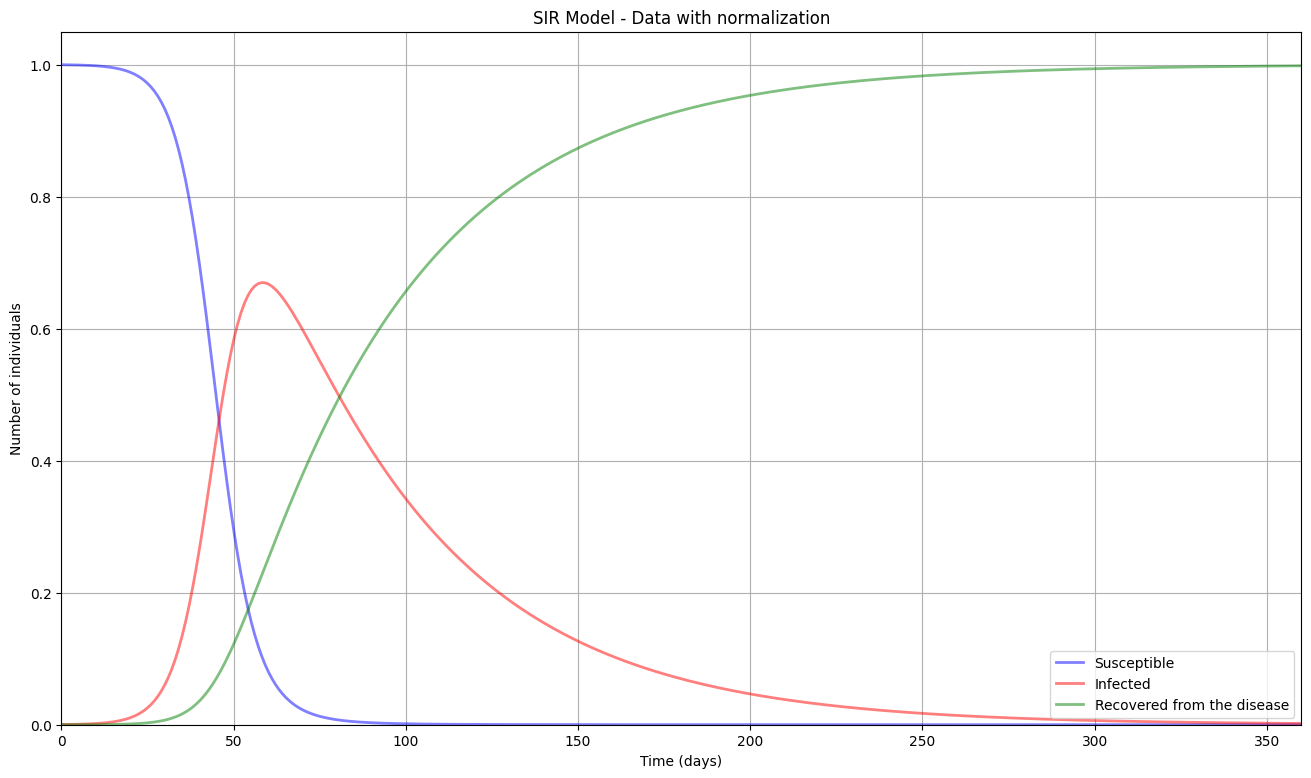

In [4]:
# Integrate the SIR equations over the time grid, t
ret = scipy.integrate.odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plots
# plot(S, I, R, t, title='Deterministic SIR Model') # Data without normalization
plot(S, I, R, t, divide_by=N, title='SIR Model - Data with normalization') # Normalized data

<h2 style='color: #026be3;'>Markov process for a population of N individuals</h2>

In the Markovian model, we redefine the parameter $\beta$, which now represents the encounter rate with susceptibles, infected, and retired individuals (including the deceased). Assuming that the duration of infection $I$ follows an exponential distribution with a mean of $1/\gamma$, the process $X = (S, I, R)$ becomes a Markov process. It exhibits the following transitions:

\begin{align*}
(S, I, R) &\rightarrow (S - 1, I + 1, R) \quad \text{at rate} \quad \beta N^{-1}IS \mathbf{1}_{\{s>0\}} \\
&\rightarrow (S, I - 1, R + 1) \quad \text{at rate} \quad \gamma I \mathbf{1}_{\{i>0\}}
\end{align*}

Here, the rate of new infection attempts is $\beta I$, and each infected individual has a probability of $S/N$ to encounter a susceptible. Therefore, the rate of new infections is $\beta\frac{IS}{N}$ if the number of susceptibles is not zero.

Each infected individual transitions out of this state at a rate of $\gamma$. Thus, the rate of exiting for at least one infected individual is $\gamma I$. 


In [5]:
# Helper function to calculate exponential waiting time
def exponential_time(rate):
    return np.random.exponential(1/rate) if rate > 0 else float('inf')

In [6]:
# Markovian model
def Markovian_SIR(N, I0, R0, beta, gamma, t_max):
    # Initial conditions
    I = I0
    R = R0
    S = N - I - R
    t = 0

    # Initialize state variables
    t_data = [t]
    S_data = [S]
    I_data = [I]
    R_data = [R]

    # Main simulation loop
    while I > 0 and t < t_max:
        # Calculate rates of infection and recovery
        rate_infection = beta * I * S / N
        rate_recovery = gamma * I

        # Calculate total rate
        total_rate = rate_infection + rate_recovery

        # Generate a random number for Poisson process
        r = np.random.random()

        # Determine which event (infection or recovery) occurs
        if r < (rate_recovery / total_rate):
            # Recovery event
            I -= 1
            R += 1
        else:
            # Infection event
            S -= 1
            I += 1
            
        # Update time
        t += exponential_time(total_rate)
            
        # Append current state to data lists
        S_data.append(S)
        I_data.append(I)
        R_data.append(R)
        t_data.append(t)

    return t_data, S_data, I_data, R_data

In [7]:
# Run simulation
t_data, S_data, I_data, R_data = Markovian_SIR(N, I0, R0, beta, gamma, t_max)

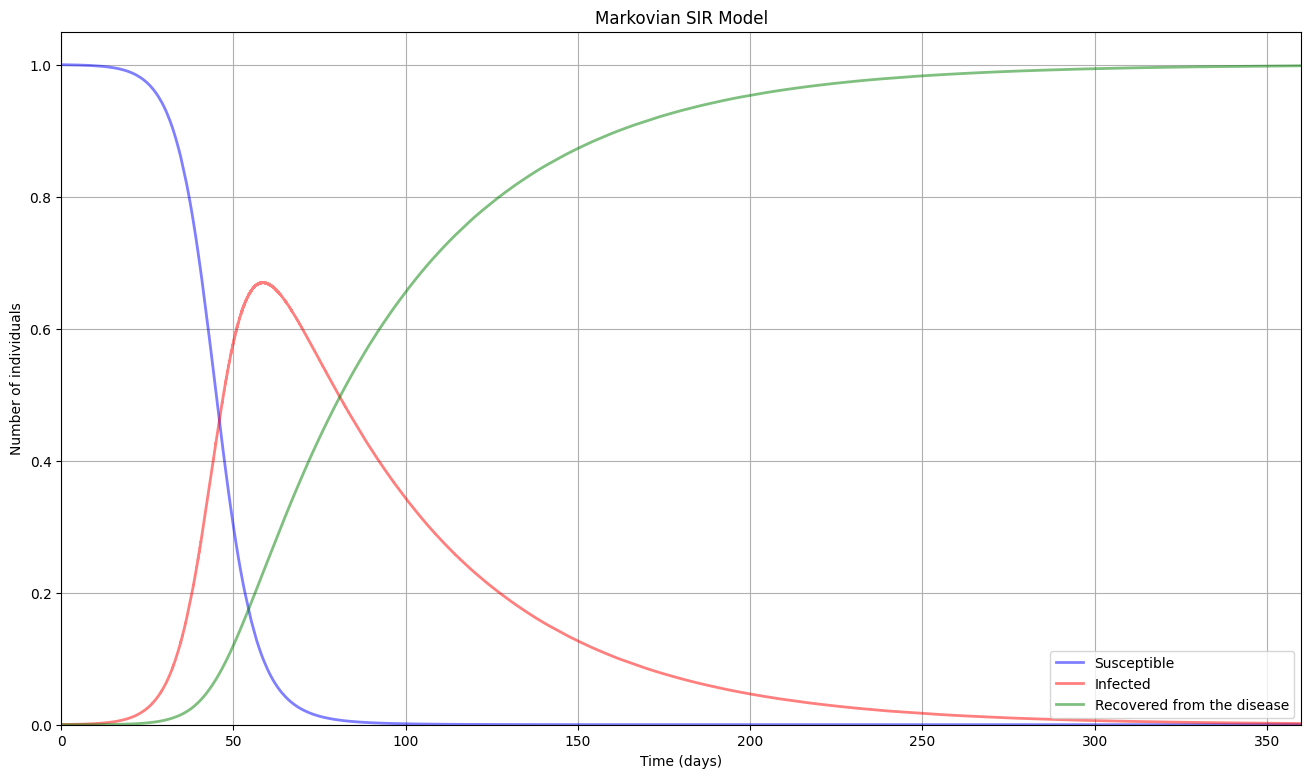

In [8]:
# Plot results
plot(S_data, I_data, R_data, t_data, divide_by=N, title='Markovian SIR Model')

We can observe that with the Markovian process, using the same parameters (N, I0, R0, beta, gamma), we obtain practically the same graph as the one obtained with the deterministic model.

<h2 style='color: #026be3;'>Find pairs of values ($ \beta , \gamma$)</h2>

- <p style='color: #026be3;'>Everyone is removed in the long term:</p>
    In this case, we are looking for parameter values that lead to the eventual elimination of the disease from the population, where everyone transitions to the removed ($R$) compartment.

- <p style='color: #026be3;'>There is a portion of the population that remains susceptible, and another portion is removed:</p>
    In this scenario, we are looking for parameter values that result in a stable equilibrium where a fraction of the population remains susceptible while another fraction is removed (recovered). The values of beta and gamma need to strike a balance between the infection rate and the recovery rate to achieve this partial equilibrium.

If we define $R_0 = \beta / \gamma$, from the theory we know that:
* If $R_0 \lt 0$, then this means that the pandemic does not explode.
* If instead $R_0 \gt 1$, i.e. $\beta \gt \gamma$, then the pandemic does explode. In this scenario, our system converges to an equilibrium in which a certain proportion of people end up in group R and a certain proportion end up in group S. The percentages depend on how large $R_0$ is.

We can look at some examples:

In [9]:
def solve_and_plot(beta=1, gamma=0.5, title=''):
    ret = scipy.integrate.odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    plot(S, I, R, t, divide_by=N, title=title) # Normalized data

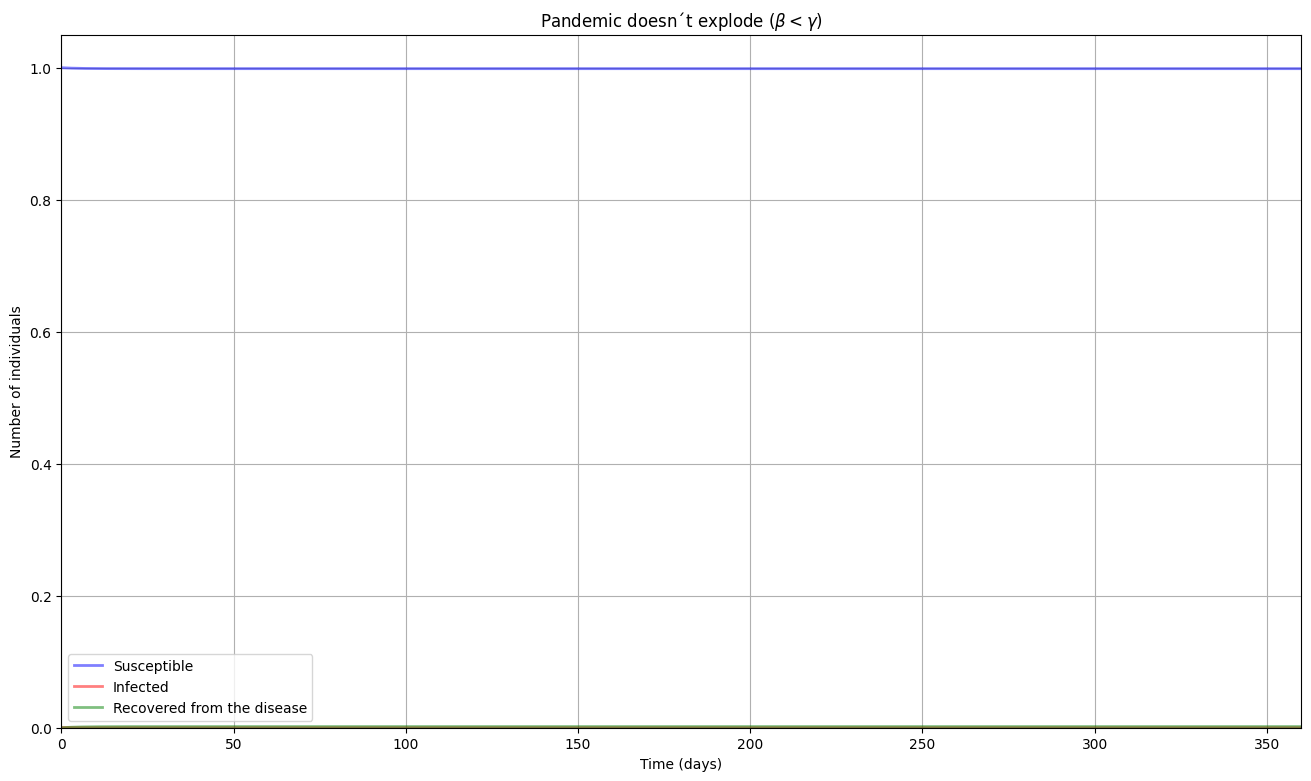

In [10]:
solve_and_plot(beta=1, gamma=1.2, title=r'Pandemic doesn´t explode ($\beta < \gamma$)')

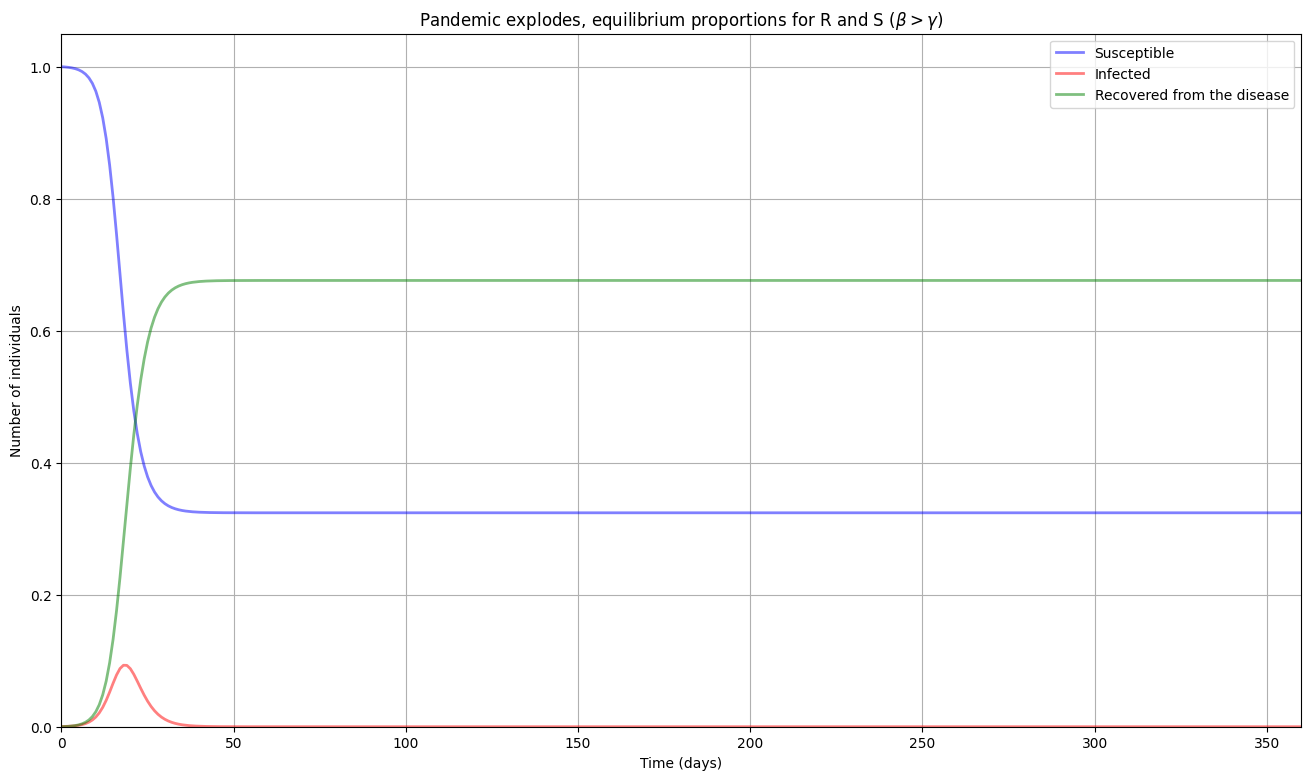

In [11]:
solve_and_plot(beta=1, gamma=0.6, title=r'Pandemic explodes, equilibrium proportions for R and S ($\beta > \gamma$)')

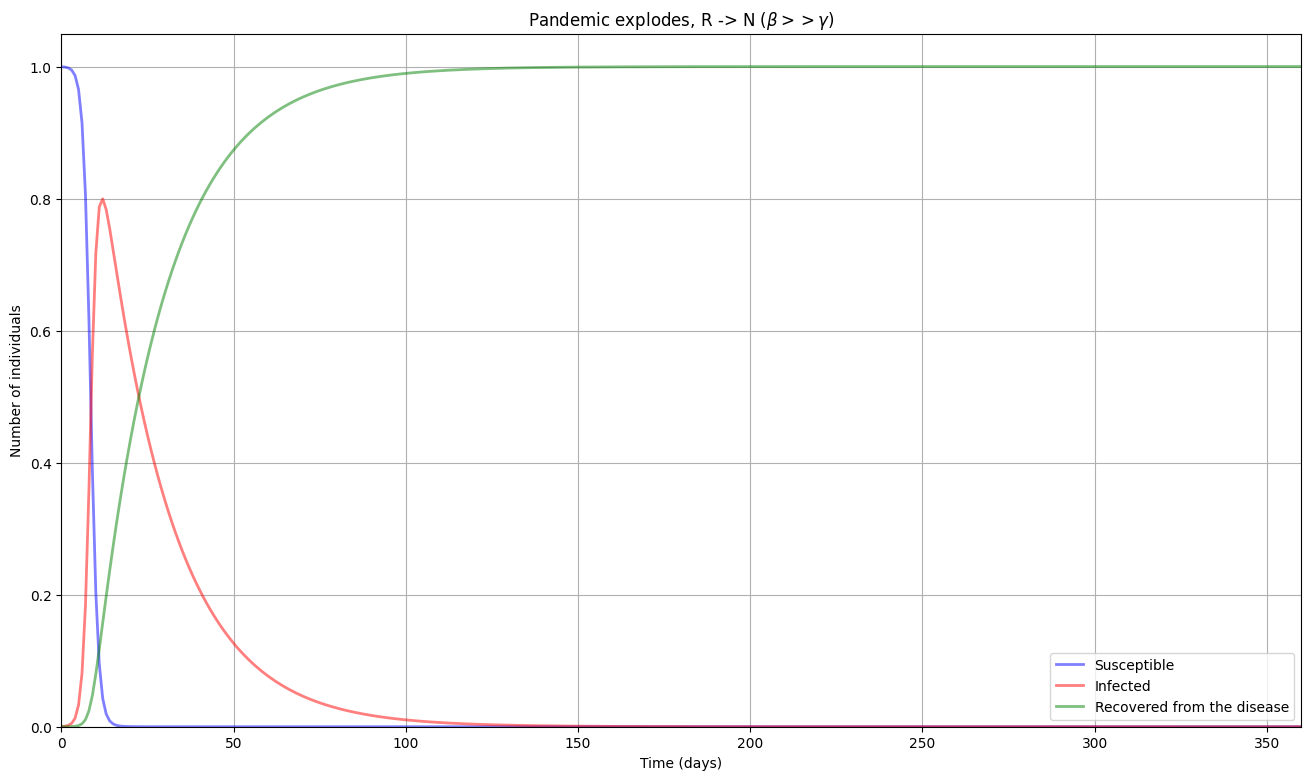

In [12]:
solve_and_plot(beta=1, gamma=0.05, title=r'Pandemic explodes, R -> N ($\beta >> \gamma$)')

Indeed we can see that the results obtained are as expected. It can be observed that, in the case where $R_0 \gt 1$, but not large enough, there is a large portion of removed and therefore infections do not occur as frequently.

To answer the question, we can give the following parameter pairs:
* Everyone is removed in the long term: $\beta = 1 , \gamma = 0.05$
* There is a portion of the population that remains susceptible, and another portion is removed: $\beta = 1 , \gamma = 0.6$

<h2 style='color: #026be3;'>Illustrate graphically the convergence of the renormalised Markov process towards the solution of the deterministic system</h2>

In [13]:
def compare_methods(N_values, I0, R0, beta, gamma, t_max):
    t = np.linspace(0, t_max, t_max)
    
    for N in N_values:
        # Deterministic SIR model
        S0 = N - I0 - R0
        y0 = S0, I0, R0    
        ret = scipy.integrate.odeint(deriv, y0, t, args=(N, beta, gamma))
        S_det, I_det, R_det = ret.T

        # Markovian SIR model
        t_markov, S_markov, I_markov, R_markov = Markovian_SIR(N, I0, R0, beta, gamma, t_max)

        # Plot comparison
        fig, ax = plt.subplots()
        ax.plot(t, np.array(S_det) / N, 'b', alpha=0.5, lw=2, label='Susceptible (Deterministic)')
        ax.plot(t, np.array(I_det) / N, 'r', alpha=0.5, lw=2, label='Infected (Deterministic)')
        ax.plot(t, np.array(R_det) / N, 'g', alpha=0.5, lw=2, label='Recovered (Deterministic)')
        ax.plot(t_markov, np.array(S_markov) / N, 'b--', alpha=0.5, lw=2, label='Susceptible (Markovian)')
        ax.plot(t_markov, np.array(I_markov) / N, 'r--', alpha=0.5, lw=2, label='Infected (Markovian)')
        ax.plot(t_markov, np.array(R_markov) / N, 'g--', alpha=0.5, lw=2, label='Recovered (Markovian)')
        ax.set_xlabel('Time (days)')
        ax.set_ylabel('Proportion of population')
        ax.set_title(f'SIR Model Comparison (N = {N})')
        ax.set_xlim(0, t_max)
        ax.set_ylim(0, 1.05)
        ax.grid(True)
        legend = ax.legend()

    plt.show()

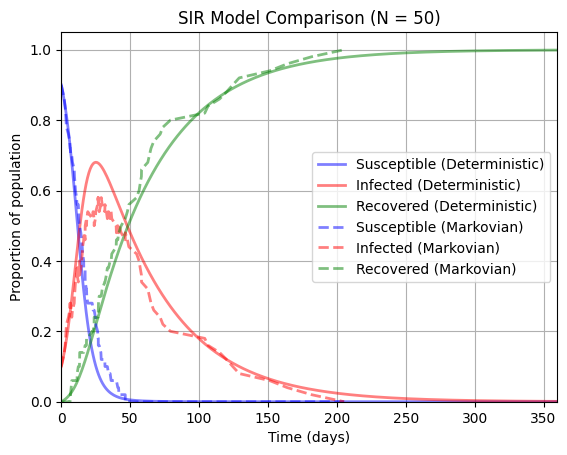

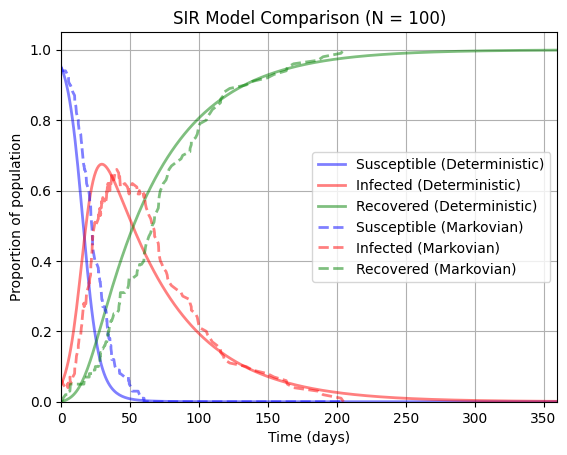

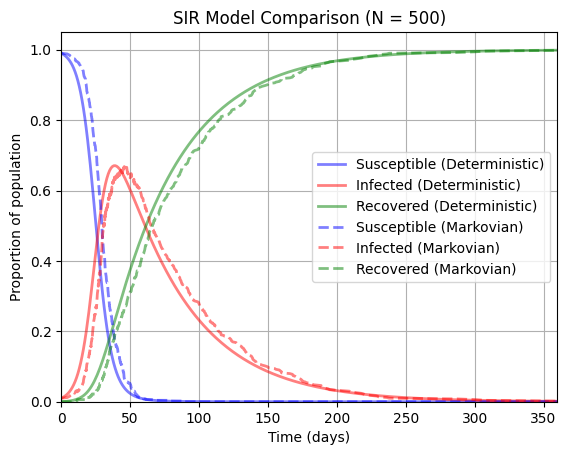

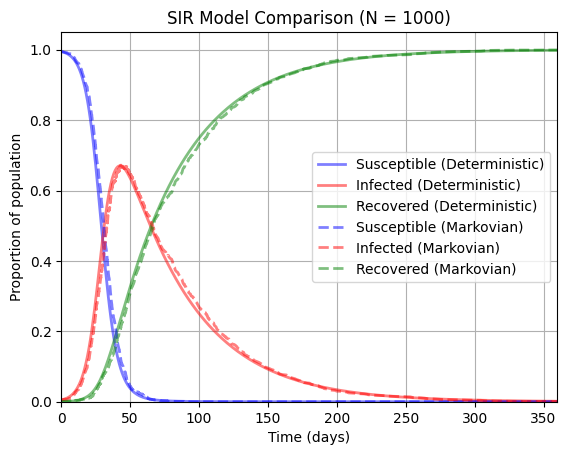

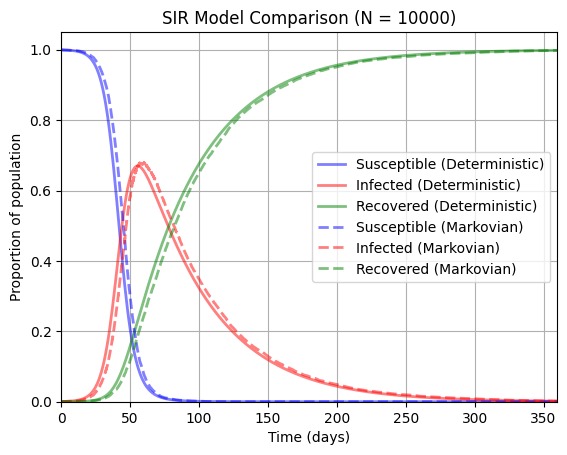

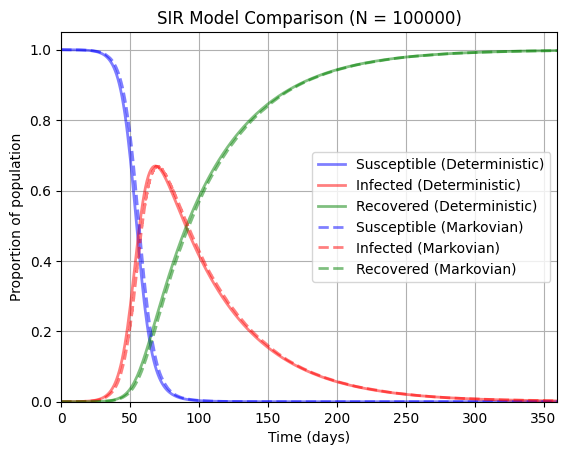

In [19]:
# Compare methods for different values of N
# N_values = [10, 50, 100, 500, 1000, 10000, 100000, 1000000]
I0 = 5
N_values = [50, 100, 500, 1000, 10000, 100000]
compare_methods(N_values, I0, R0, beta, gamma, t_max)

We can see that from the result $N \gt 10000$ both curves are already practically identical.

<h2 style='color: #026be3;'>Parameter estimation from French public health data</h2>

Using data from Santé Publique France, which has 4 columns: hospitalisations (hos), admissions to intensive care (rea), deaths (dc) and people sent home (rad) for each day and for each département, how would you go about estimating gamma and beta for a given department?

In [20]:
df = pd.read_csv('covid-hospit-incid-2023-03-31-18h01.csv', sep=';')
# Stay with data from dep 01
df = df[df['dep'] == "92"]
# Tranform date to number of days since first date
df['jour'] = pd.to_datetime(df['jour'])
df['jour'] = (df['jour'] - df['jour'].min())  / np.timedelta64(1,'D')
print(df.head())

       dep  jour  incid_hosp  incid_rea  incid_dc  incid_rad
101936  92   0.0          95         19         3         13
101937  92   1.0          66         14         4         15
101938  92   2.0          99         17         9         22
101939  92   3.0         114         25         3         17
101940  92   4.0         124         22         6         25


In [21]:
# We will use the number of hospitalizations and people in ICU as the number of infected
I1 = np.array( df['incid_hosp'] + df['incid_rea'] )
# We will use the number of deaths and people sent home as the number of recovered
R1 = np.array( df['incid_dc'] + df['incid_rad'] )

For estimating the data we can base our analysis in the article [1]. In this article, the authors proposed a methodology of fitting the SIR model to in-hospital deaths, we are going to use this methodology but using the infected data instead of the in-hospital deaths. The infected that is going to be used is the sum of the hospitalisations and the admissions to intensive care.

For fitting the SIR model, the method used is the graphical fit to make the SIR model coincide with the 7-day moving average infected curve. This choice turned out to be precise enough to be able to “manually” adjust the parameters of the model, given the significant duration.


[1] https://hal.science/hal-02923715/document

In [22]:
# Calculate a mean moving average
def cal_moving_average(I, R, window_size=7):
    I_avg = np.convolve(I, np.ones(window_size) / window_size, mode='full')
    R_avg = np.convolve(R, np.ones(window_size) / window_size, mode='full')
    t_avg = np.arange(window_size / 2, len(I) - window_size / 2 + 1)
    
    return t_avg, I_avg, R_avg

t_avg, I_avg, R_avg = cal_moving_average(I1, R1, window_size=7)

In [23]:
# Initial conditions
N = 500 # Initial population scaled
I0 = I_avg[0] # Number of initial infected
R0 = R_avg[0] # Number of initial recovered individuals
S0 = N - I0 - R0 # Number of initial susceptible individuals

# Infection and recovery rates
beta = 0.35 # Infection rate
gamma = 1/15 # Recovery rate (1/days) (~2 weeks: https://www.webmd.com/covid/covid-recovery-overview)

# Initial conditions vector
y0 = S0, I0, R0

# Days (in days)
t_max = 200

# A grid of time points (in days)
t = np.linspace(0, t_max, t_max)
ret = scipy.integrate.odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T
I = np.array(I)

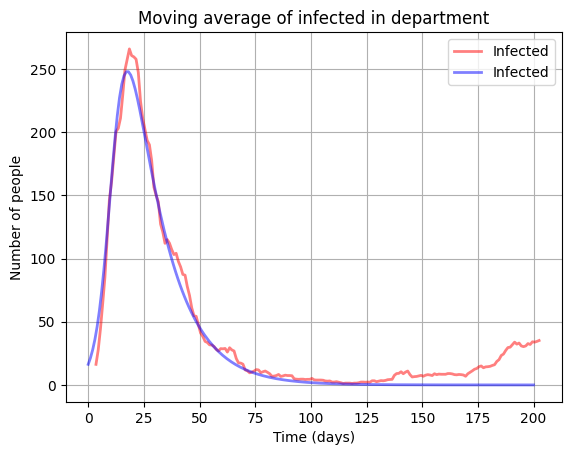

In [24]:
divide_by = 1

# Plot data
fig, ax = plt.subplots()
ax.plot(t_avg[:200], I_avg[:200] / divide_by, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t[:200], I[:200] / divide_by, 'b', alpha=0.5, lw=2, label='Infected')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number of people')
ax.set_title("Moving average of infected in department")
ax.grid(True)
legend = ax.legend()
plt.show()


We can conclude that our simulated model with $\gamma = 1/15$ and $\beta = 0.35$ graphically fits very nicely the analyzed data. However, it's important to keep in mind that the simulated model is not taking into account different external social factors (as prevention regulations).

*Note: We have also decided to study only the first "wave" of the disease in the department.*